# Illustration of pixelated lensing operator in _SLITronomy_

__Author__ : Aymeric Galan

__Created__ : 16/12/19

__Updated__ : 7/12/20

This notebooks builds different instances of a `slitronomy.Lensing.LensingOperator` object, used by all SLITronomy solvers, varying the interpolation type (nearest-neighbour or bilinear) and supersampling factor of source plane resolution. It then illustrates the difference by comparing these pixelated lensing / de-lensing operations with a continuous analytical mapping.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as l_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

from slitronomy.Lensing.lensing_operator import LensingOperator
from lenstronomy.ImSim.Numerics.numerics_subframe import NumericsSubFrame
from slitronomy.Util.plot_util import nice_colorbar
from slitronomy.Util import util

%matplotlib inline

plt.rcParams['image.interpolation'] = 'none'

dark_bg_mode = False

## General settings

In [2]:
# image plane size
num_pix = 100

# pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2) -->  if 1, means we work in pixel units

## Simulate a lens with _lenstronomy_

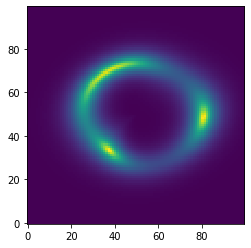

In [3]:
# prepare mock image simulation
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = l_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                           inverse=False, left_lower=False)
data_class = ImageData(image_data=np.empty((num_pix, num_pix)), 
                       ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0, transform_pix2angle=Mpix2coord)

# no convolution for this illustration
kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

# define lens mass model
lens_model_list = ['SIE', 'SHEAR_GAMMA_PSI']  # singular isothernmal sphere model
kwargs_spemd = {'theta_E': 2, 'center_x': 0, 'center_y': 0, 'e1': -0.1, 'e2': 0.1}
kwargs_shear = {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# define source light model
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_ellipse_source = {'amp': 100, 'R_sersic': 0.6, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                'center_x': 0.3, 'center_y': 0.1}
kwargs_source = [kwargs_sersic_ellipse_source]
source_model_class = LightModel(light_model_list=source_model_list)

# numeric settings
kwargs_numerics = {'supersampling_factor': 1}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        kwargs_numerics=kwargs_numerics)

image_sim = imageModel.image(kwargs_lens, kwargs_source)
data_class.update_data(image_sim)

plt.imshow(image_sim, origin='lower')
plt.show()

## Get the simulated source

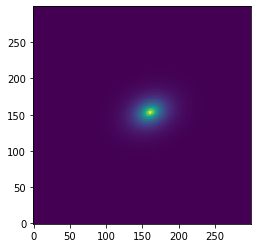

In [4]:
# get the coordinates arrays of image plane (the 'thetas')
x_grid, y_grid = data_class.pixel_coordinates
theta_x_1d = l_util.image2array(x_grid)
theta_y_1d = l_util.image2array(y_grid)

# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
theta_x_src_1d, theta_y_src_1d = l_util.make_grid(numPix=num_pix, deltapix=delta_pix)
theta_x_src_ss2_1d, theta_y_src_ss2_1d = l_util.make_grid(numPix=num_pix, deltapix=delta_pix, subgrid_res=2)
theta_x_src_ss3_1d, theta_y_src_ss3_1d = l_util.make_grid(numPix=num_pix, deltapix=delta_pix, subgrid_res=3)

# get the light distribution in source plane, at different resolution
source_sim = l_util.array2image(source_model_class.surface_brightness(theta_x_src_1d, theta_y_src_1d, 
                                                                      kwargs_source))
source_sim_ss2 = l_util.array2image(source_model_class.surface_brightness(theta_x_src_ss2_1d, theta_y_src_ss2_1d, 
                                                                          kwargs_source))
source_sim_ss3 = l_util.array2image(source_model_class.surface_brightness(theta_x_src_ss3_1d, theta_y_src_ss3_1d, 
                                                                          kwargs_source))

plt.imshow(source_sim_ss3, origin='lower')
plt.show()

## Build lensing operators, varying interpolation & resolution

In [5]:
image_grid_class = imageModel.ImageNumerics.grid_class
source_grid_class_ss1 = NumericsSubFrame(data_class, psf_class, supersampling_factor=1).grid_class
source_grid_class_ss2 = NumericsSubFrame(data_class, psf_class, supersampling_factor=2).grid_class
source_grid_class_ss3 = NumericsSubFrame(data_class, psf_class, supersampling_factor=3).grid_class

lensing_simple_ss1 = LensingOperator(lens_model_class, image_grid_class, source_grid_class_ss1,
                                     num_pix, source_interpolation='nearest')
lensing_simple_ss2 = LensingOperator(lens_model_class, image_grid_class, source_grid_class_ss2,
                                     num_pix, source_interpolation='nearest')
lensing_simple_ss3 = LensingOperator(lens_model_class, image_grid_class, source_grid_class_ss3,
                                     num_pix, source_interpolation='nearest')

lensing_interp_ss1 = LensingOperator(lens_model_class, image_grid_class, source_grid_class_ss1,
                                     num_pix, source_interpolation='bilinear')
lensing_interp_ss2 = LensingOperator(lens_model_class, image_grid_class, source_grid_class_ss2,
                                     num_pix, source_interpolation='bilinear')
lensing_interp_ss3 = LensingOperator(lens_model_class, image_grid_class, source_grid_class_ss3,
                                     num_pix, source_interpolation='bilinear')

## Compute mappings

### from image to source plane ('F^T' operator)

In [6]:
delensed_simple_ss1 = lensing_simple_ss1.image2source_2d(image_sim, kwargs_lens=kwargs_lens)
delensed_simple_ss2 = lensing_simple_ss2.image2source_2d(image_sim, kwargs_lens=kwargs_lens)
delensed_simple_ss3 = lensing_simple_ss3.image2source_2d(image_sim, kwargs_lens=kwargs_lens)

delensed_interp_ss1 = lensing_interp_ss1.image2source_2d(image_sim, kwargs_lens=kwargs_lens)
delensed_interp_ss2 = lensing_interp_ss2.image2source_2d(image_sim, kwargs_lens=kwargs_lens)
delensed_interp_ss3 = lensing_interp_ss3.image2source_2d(image_sim, kwargs_lens=kwargs_lens)

### from source to image plane ('F' operator)

In [7]:
# from source plane to image plane ('F' operator)
lensed_simple_ss1 = lensing_simple_ss1.source2image_2d(source_sim, kwargs_lens=kwargs_lens)
lensed_simple_ss2 = lensing_simple_ss2.source2image_2d(source_sim_ss2, kwargs_lens=kwargs_lens)
lensed_simple_ss3 = lensing_simple_ss3.source2image_2d(source_sim_ss3, kwargs_lens=kwargs_lens)

lensed_interp_ss1 = lensing_interp_ss1.source2image_2d(source_sim, kwargs_lens=kwargs_lens)
lensed_interp_ss2 = lensing_interp_ss2.source2image_2d(source_sim_ss2, kwargs_lens=kwargs_lens)
lensed_interp_ss3 = lensing_interp_ss3.source2image_2d(source_sim_ss3, kwargs_lens=kwargs_lens)

## Final plot

In [8]:
def plot_image_plane(ax, data, show_zoom=True, ref_image=None):
    from mpl_toolkits.axes_grid1 import inset_locator
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if ref_image is not None:
        vmin = ref_image.min()
        vmax = ref_image.max()
    else:
        vmin, vmax = None, None
    im = ax.imshow(data, origin='lower', cmap='cubehelix', vmin=vmin, vmax=vmax)
    if show_zoom:
        ax_z = inset_locator.zoomed_inset_axes(ax, 2.2, loc='lower right')
        ax_z.imshow(data, origin='lower', cmap='cubehelix')
        ax_z.set_xlim(25, 45)
        ax_z.set_ylim(65, 78)
        ax_z.spines['bottom'].set_color('white')
        ax_z.spines['top'].set_color('white') 
        ax_z.spines['right'].set_color('white')
        ax_z.spines['left'].set_color('white')
        ax_z.tick_params(axis='x', colors='#00000000')
        ax_z.tick_params(axis='y', colors='#00000000')
        #inset_locator.mark_inset(ax, ax_z, loc1=1, loc2=2, fc="none", ec="0.5")
    else:
        ax_z = None
    return ax, ax_z

def plot_source_plane(ax, data, ref_image=None):
    nx, ny = data.shape
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    if ref_image is not None:
        vmin = ref_image.min()
        vmax = ref_image.max()
    else:
        vmin, vmax = None, None
    im = ax.imshow(data, origin='lower', cmap='cubehelix', vmin=vmin, vmax=vmax)
    ax.set_xlim(int(nx/3), int(2*nx/3))
    ax.set_ylim(int(ny/3), int(2*ny/3))
    return ax  #, ax_z

def text(ax, string, fontsize=14):
    ax.text(0.05, 0.95, string, color='white', va='top', ha='left', fontsize=fontsize,
            transform=ax.transAxes)
    return ax

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  after removing the cwd from sys.path.
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Users/aymericg/anaconda3/envs/pystro

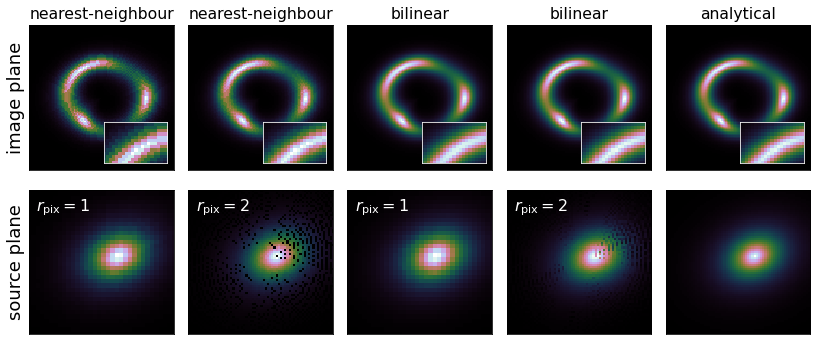

In [9]:
if dark_bg_mode:
    plt.style.use('dark_background')

plt.rc('font', size=13)
plt.rc('axes', labelsize=18)
txt_fontsize = 16

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

ax = axes[0, 4]
ax.set_title("analytical")
ax, ax_z = plot_image_plane(ax, image_sim, show_zoom=True)

ax = axes[0, 0]
ax.set_ylabel("image plane")
ax.set_title("nearest-neighbour")
#text(ax, "s.s.$=1$")
ax, ax_z = plot_image_plane(ax, lensed_simple_ss1)

ax = axes[0, 1]
ax.set_title("nearest-neighbour")
#text(ax, "s.s.$=2$")
ax, ax_z = plot_image_plane(ax, lensed_simple_ss2)

ax = axes[0, 2]
ax.set_title("bilinear")
#text(ax, "s.s.$=1$")
ax, ax_z = plot_image_plane(ax, lensed_interp_ss1)

ax = axes[0, 3]
ax.set_title("bilinear")
#text(ax, "s.s.$=2$")
ax, ax_z = plot_image_plane(ax, lensed_interp_ss2)

ax = axes[1, 4]
im = plot_source_plane(ax, source_sim_ss2)

ax = axes[1, 0]
ax.set_ylabel("source plane")
text(ax, r"$r_{\rm pix}=1$", fontsize=txt_fontsize)
im = plot_source_plane(ax, delensed_simple_ss1)

ax = axes[1, 1]
text(ax, r"$r_{\rm pix}=2$", fontsize=txt_fontsize)
im = plot_source_plane(ax, delensed_simple_ss2)

ax = axes[1, 2]
text(ax, r"$r_{\rm pix}=1$", fontsize=txt_fontsize)
im = plot_source_plane(ax, delensed_interp_ss1)

ax = axes[1, 3]
text(ax, r"$r_{\rm pix}=2$", fontsize=txt_fontsize)
im = plot_source_plane(ax, delensed_interp_ss2)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.02)
plt.show()

In [10]:
fig_name = 'lensing_mapping.pdf'
if dark_bg_mode:
    dir_name = 'figures_darkBG'
else:
    dir_name = 'figures'
fig.savefig(os.path.join(dir_name, fig_name), dpi=100, bbox_inches='tight')